<h1>Распознавание номера авто</h1>

In [1]:
import os
import cv2
import numpy as np
from typing import Any, Dict, List, Optional, Tuple
import numpy as np
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import rotate
from skimage.color import rgb2gray
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import itertools
import glob
import tensorflow as tf
import requests,io
print('TensorFlow version:', tf.__version__)



TensorFlow version: 2.16.1


Код для загрузки файла обученной нейросети с https://disk.yandex.ru/d/QavLH1pvpRhLOA :

In [2]:
if not os.path.isfile('./model_resnet.tflite'):
    API_ENDPOINT = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key={}'
    link_r = requests.get(API_ENDPOINT.format('https://disk.yandex.ru/d/QavLH1pvpRhLOA'))
    response= requests.get(link_r.json()['href'])
    if response.status_code == 200:
        with open("./model_resnet.tflite", 'wb') as f:
            f.write(response.content)


Загружаем фото автомобилей

In [3]:
tich_file=glob.glob('./Object_Detection/test/*')
print(len(tich_file),tich_file)

5 ['./Object_Detection/test\\my_1.jpg', './Object_Detection/test\\my_2-2.jpg', './Object_Detection/test\\my_4.jpg', './Object_Detection/test\\my_5.jpg', './Object_Detection/test\\my_6.jpg']


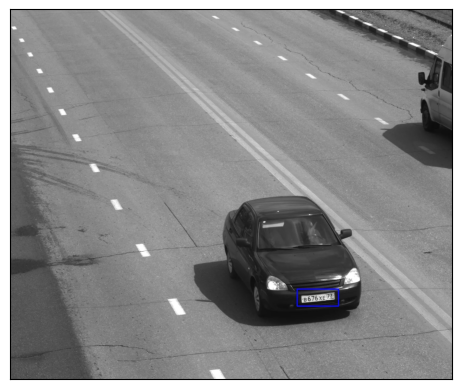

In [4]:
img_name1=tich_file[0]
image = cv2.imread(img_name1)
plt.imshow(image)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

Object Detection

Загружаем предобученную tflite модель "ssd mobilenet v2 320x320" для нахождения расположения номера машины

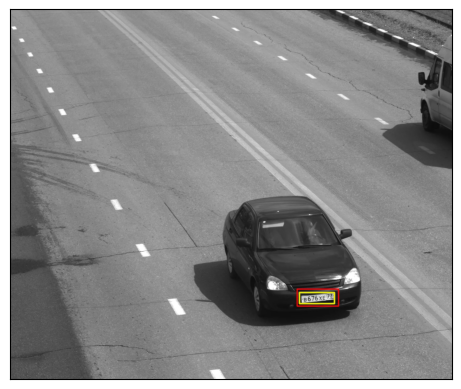

In [5]:
i=0
img_name1=tich_file[i]
path = img_name1   
image0 = cv2.imread(img_name1, 1)
image_height, image_width, _ = image0.shape
image = cv2.resize(image0, (1024,1024))
image = image.astype(np.float32)
paths='./model_resnet.tflite'
interpreter = tf.lite.Interpreter(model_path=paths)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
X_data1=np.float32(image.reshape(1,1024, 1024,3))
input_index = (interpreter.get_input_details()[0]['index'])
interpreter.set_tensor(input_details[0]['index'], X_data1)
interpreter.invoke()
detection = interpreter.get_tensor(output_details[0]['index'])
net_out_value2 = interpreter.get_tensor(output_details[1]['index'])
net_out_value3 = interpreter.get_tensor(output_details[2]['index'])
net_out_value4 = interpreter.get_tensor(output_details[3]['index'])
img = image0
razmer=img.shape

img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Converts from one colour space to the other
img3=img[:,:,:]

box_x =int( detection[0,0,0] * image_height)
box_y = int(detection[0,0,1] * image_width)
box_width =int( detection[0,0,2] * image_height)
box_height = int(detection[0,0,3] * image_width)

cv2.rectangle(img2, ( box_y,box_x), (box_height,box_width ), (230, 230, 21), thickness=5)
    
plt.imshow(img2)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

In [6]:
net_out_value3

array([[0.3433737 , 0.06759817, 0.03687156, 0.02914917, 0.02670897,
        0.02512589, 0.02428008, 0.02227966, 0.01993904, 0.0194088 ]],
      dtype=float32)

оставляем только номер

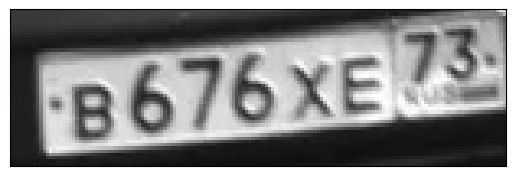

In [7]:
image = image0[box_x:box_width,box_y:box_height,:]
img2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

<h1> Подготовка изображений </h1>

пытаемся выровнить его с помощь преобразования Хафа 

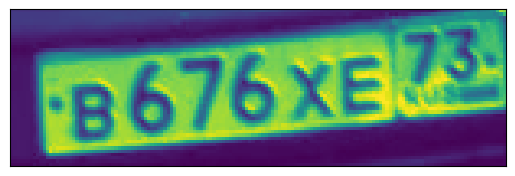

In [8]:
grayscale = rgb2gray(image)
plt.imshow(grayscale)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

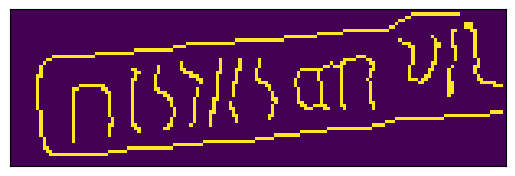

In [9]:
edges = canny(grayscale, sigma=3.0)
plt.imshow(edges)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

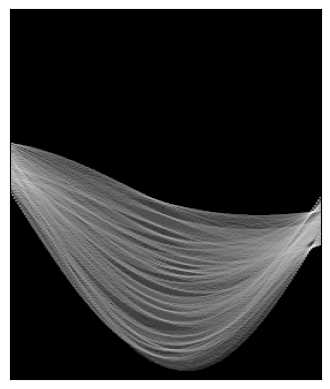

In [10]:
out, angles, distances = hough_line(edges)
h, theta, d=out, angles, distances 
angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]
plt.imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

In [11]:
_, angles_peaks, _ = hough_line_peaks(out, angles, distances, num_peaks=20)
angle=np.mean(np.rad2deg(angles_peaks))
angle

84.5

In [12]:
if 0 <= angle <= 90:
    rot_angle = angle - 90
elif -45 <= angle < 0:
    rot_angle = angle - 90
elif -90 <= angle < -45:
    rot_angle = 90 + angle
if abs(rot_angle)>20:
    rot_angle=0
print('угол наклона',rot_angle )

угол наклона -5.5


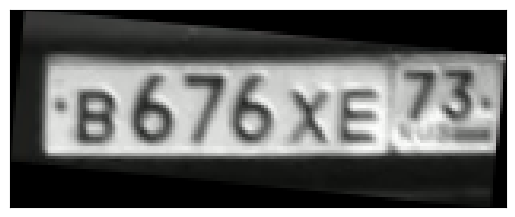

In [13]:
rotated = rotate(image, rot_angle, resize=True)*255
rotated = rotated.astype(np.uint8)
plt.imshow(rotated)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

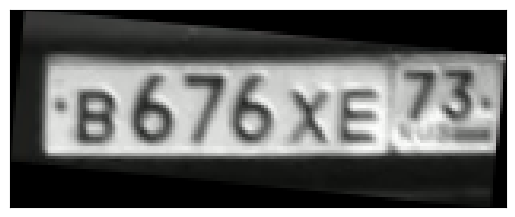

In [14]:
rotated1=rotated[:,:,:]
if rotated.shape[1]/rotated.shape[0]<2:
    minus=np.abs(int(np.sin(np.radians(rot_angle))*rotated.shape[0]))
    rotated1=rotated[minus:-minus,:,:]
    print(minus)
plt.imshow(rotated1)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

пытаемся увеличить конрастность

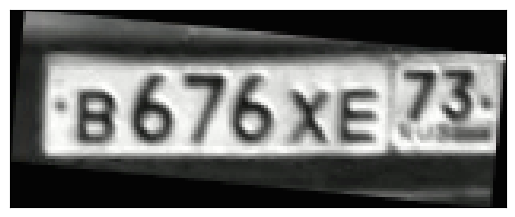

In [15]:
lab = cv2.cvtColor(rotated1, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl = clahe.apply(l)
limg = cv2.merge((cl,a,b))
final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
# final2=rotated1-final
plt.imshow(final)
plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
plt.show()

<h1> OCR </h1>

In [16]:
letters=['0' ,'1' ,'2','3' ,'4' ,'5', '6', '7', '8','9', 'A', 'B', 'C', 'E' ,'H','K', 'M','O', 'P', 'T', 'X', 'Y']

def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters):
                outstr += letters[c]
        ret.append(outstr)
    return ret

Загружаем  обученную tflite модель CNN-LSTM-CTC для распознавания символов

In [17]:
paths='./model1_nomer.tflite'
interpreter = tf.lite.Interpreter(model_path=paths)
interpreter.allocate_tensors()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
img =final
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (128,64))
img = img.astype(np.float32)
img /= 255

img1=img.T
img1.shape
X_data1=np.float32(img1.reshape(1,128, 64,1))
input_index = (interpreter.get_input_details()[0]['index'])
interpreter.set_tensor(input_details[0]['index'], X_data1)

interpreter.invoke()

net_out_value = interpreter.get_tensor(output_details[0]['index'])
pred_texts = decode_batch(net_out_value)
pred_texts

['B676XE73']

Predicted: B676XE73


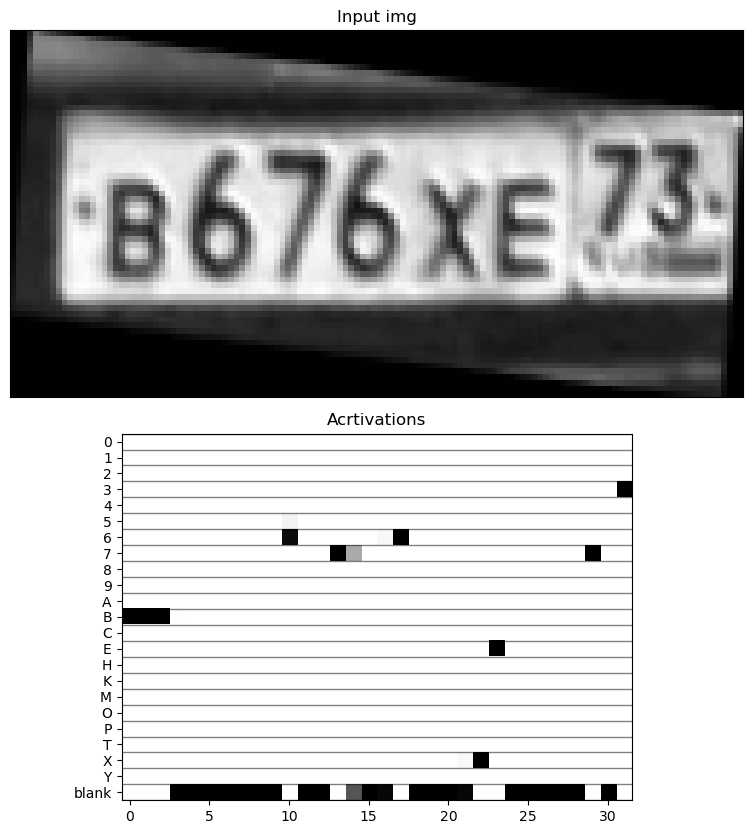

In [18]:
fig = plt.figure(figsize=(10, 10))
outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
ax1 = plt.Subplot(fig, outer[0])
fig.add_subplot(ax1)
ax2 = plt.Subplot(fig, outer[1])
fig.add_subplot(ax2)
print('Predicted:', pred_texts[0])
img = X_data1[0,:, :, 0].T
ax1.set_title('Input img')
ax1.imshow(img, cmap='gray')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_title('Acrtivations')
ax2.imshow(net_out_value[0].T, cmap='binary', interpolation='nearest')
ax2.set_yticks(list(range(len(letters) + 1)))
ax2.set_yticklabels(letters + ['blank'])
ax2.grid(False)
for h in np.arange(-0.5, len(letters) + 1 + 0.5, 1):
    ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)

#ax.axvline(x, linestyle='--', color='k')
plt.show()

<h1> Объединение в один код </h1>

In [3]:
import psycopg2
from psycopg2 import sql
import os
import cv2
import numpy as np
from typing import Any, Dict, List, Optional, Tuple
import numpy as np
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import rotate
from skimage.color import rgb2gray
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import itertools
import glob
import tensorflow as tf
import requests,io
print('TensorFlow version:', tf.__version__)

def connect_to_db():
    # Подключение к базе данных
    conn = psycopg2.connect(
            dbname="traffic_violators",
            user="postgres",
            password="postgres",
            host="localhost",
            port="5432"
    )
    return conn

def create_table(conn):
    try:
        # Подключение к базе данных        
        cursor = conn.cursor()
        
        # SQL-запрос для создания таблицы
        create_table_query = '''
        CREATE TABLE IF NOT EXISTS violations (
            id SERIAL PRIMARY KEY,
            number TEXT,
            comment TEXT,
            address TEXT,
            date DATE
        );
        '''
        
        # Выполнение запроса
        cursor.execute(create_table_query)
        
        # Сохранение изменений
        conn.commit()
        print("Таблица успешно создана")
        
    except Exception as e:
        print(f"Произошла ошибка: {e}")
        
    finally:
        # Закрытие курсора и соединения
        if cursor:
            cursor.close()
        # if conn:
        #     conn.close()

def connect_and_save_to_db(conn, number: str, comment: str, address: str, date: str):
    # Подключение к базе данных
    cursor = conn.cursor()

    try:
        # SQL-запрос для вставки данных
        insert_query = sql.SQL("INSERT INTO violations (number, comment, address, date) VALUES (%s, %s, %s, %s)")  
        # Выполнение запроса   
        cursor.execute(insert_query, (number, comment, address, date))  
        
        # Сохранение изменений
        conn.commit()
        
        print("Данные успешно сохранены в БД")
        
    except Exception as e:
        print(f"Произошла ошибка: {e}")
        
    finally:
        # Закрытие курсора и соединения
        if cursor:
            cursor.close()
        # if conn:
        #     conn.close()

# Функция для удаления таблицы vacancies
def drop_table():
    try:
        connection = psycopg2.connect(
                dbname="traffic_violators",
                user="postgres",
                password="postgres",
                host="localhost",
                port="5432"
            )
            
        cursor = connection.cursor()
        cursor.execute("DROP TABLE IF EXISTS violations")
    
        connection.commit()
        cursor.close()
        print("Таблица 'violations' успешно удалена.")
    
    except Exception as e:
        print(f"Произошла ошибка: {e}")
    
    finally:
        # Закрытие курсора и соединения
        if cursor:
            cursor.close()
        # if connection:
        #     connection.close()

### Новая функция для записывания нарушителей
def check_violator(pred_texts):
    for text in pred_texts:
        # print(f"Текущий номер: {text}")
        answer = input("Нарушитель? (да/нет): ")
        
        if answer.lower() == "да":
            comment = input("Введите комментарий: ")
            address = input("Введите адрес: ")
            date = input("Введите дату (гггг-мм-дд): ")
            # date = date.today().strftime("%Y-%m-%d")

            conn = connect_to_db()  # Соединяемся с базой данных
            create_table(conn) # Создание таблицы
            connect_and_save_to_db(conn, text, comment, address, date) # Сохранение данных
            conn.close()  #Закрытие соединения с БД
    # cur.close()

TensorFlow version: 2.16.1


5 ['./Object_Detection/test\\my_1.jpg', './Object_Detection/test\\my_2-2.jpg', './Object_Detection/test\\my_6.jpg', './Object_Detection/test\\Untitled.ipynb', './Object_Detection/test\\Untitled1.ipynb']


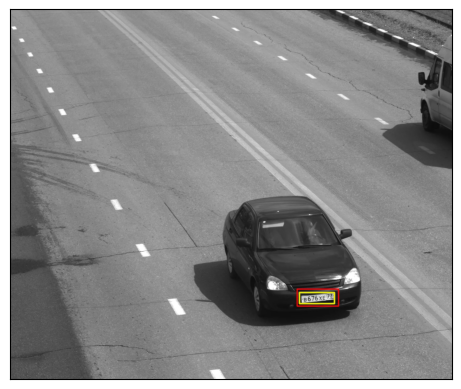

['B676XE73']


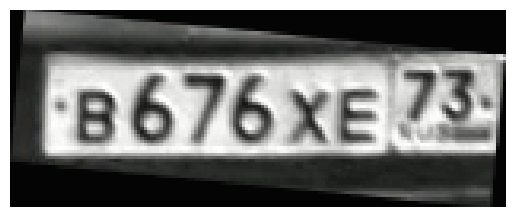

Нарушитель? (да/нет):  нет


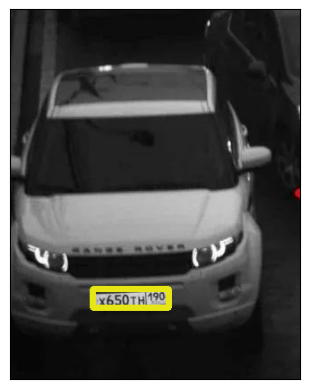

['X650TH190']


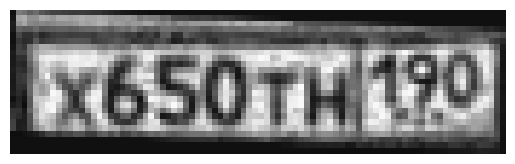

Нарушитель? (да/нет):  нет


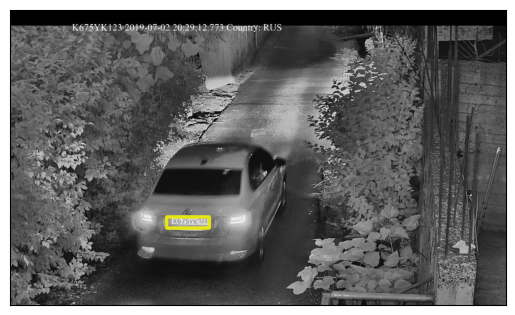

['A675YK163']


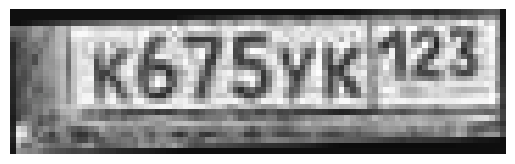

Нарушитель? (да/нет):  да
Введите комментарий:  ===
Введите адрес:  ===
Введите дату (гггг-мм-дд):  2022-11-12


Таблица успешно создана
Данные успешно сохранены в БД


AttributeError: 'NoneType' object has no attribute 'shape'

In [2]:
# Перезагрузка папки с фотографиями
tich_file=glob.glob('./Object_Detection/test/*')
print(len(tich_file),tich_file)

#OCR
letters=['0' ,'1' ,'2','3' ,'4' ,'5', '6', '7', '8','9', 'A', 'B', 'C', 'E' ,'H','K', 'M','O', 'P', 'T', 'X', 'Y']
def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters):
                outstr += letters[c]
        ret.append(outstr)
    return ret

for i in range(len(tich_file)):
    img_name1=tich_file[i]
    path = img_name1   
    image0 = cv2.imread(img_name1, 1)
    image_height, image_width, _ = image0.shape
    image = cv2.resize(image0, (1024,1024))
    image = image.astype(np.float32)
    paths='./model_resnet.tflite'
    interpreter = tf.lite.Interpreter(model_path=paths)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    X_data1=np.float32(image.reshape(1,1024, 1024,3))
    input_index = (interpreter.get_input_details()[0]['index'])
    interpreter.set_tensor(input_details[0]['index'], X_data1)
    interpreter.invoke()
    detection = interpreter.get_tensor(output_details[0]['index'])
    net_out_value2 = interpreter.get_tensor(output_details[1]['index'])
    net_out_value3 = interpreter.get_tensor(output_details[2]['index'])
    net_out_value4 = interpreter.get_tensor(output_details[3]['index'])
    img = image0
    razmer=img.shape

    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Converts from one colour space to the other
    img3=img[:,:,:]

    box_x =int( detection[0,0,0] * image_height)
    box_y = int(detection[0,0,1] * image_width)
    box_width =int( detection[0,0,2] * image_height)
    box_height = int(detection[0,0,3] * image_width)
    if  np.min(detection[0,0,:])>=0:
        cv2.rectangle(img2, ( box_y,box_x), (box_height,box_width ), (230, 230, 21), thickness=5)

        plt.imshow(img2)
        plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
        plt.show()
        image = img3[box_x:box_width,box_y:box_height,:]
        grayscale = rgb2gray(image)
        edges = canny(grayscale, sigma=3.0)
        out, angles, distances = hough_line(edges)
        _, angles_peaks, _ = hough_line_peaks(out, angles, distances, num_peaks=20)
        angle=np.mean(np.rad2deg(angles_peaks))
        if 0 <= angle <= 90:
            rot_angle = angle - 90
        elif -45 <= angle < 0:
            rot_angle = angle - 90
        elif -90 <= angle < -45:
            rot_angle = 90 + angle
        if abs(rot_angle)>20:
            rot_angle=0
        rotated = rotate(image, rot_angle, resize=True)*255
        rotated =rotated.astype(np.uint8)
        rotated1=rotated[:,:,:]
        minus=np.abs(int(np.sin(np.radians(rot_angle))*rotated.shape[0]))
        if rotated.shape[1]/rotated.shape[0]<2 and minus >10:

            rotated1=rotated[minus:-minus,:,:]
        lab= cv2.cvtColor(rotated1, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        limg = cv2.merge((cl,a,b))
        final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        
        paths='./model1_nomer.tflite'
        interpreter = tf.lite.Interpreter(model_path=paths)
        interpreter.allocate_tensors()
        # Get input and output tensors.
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        #img =rotated1
        img =final # лучше работает при плохом освещении

        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (128,64))
        img = img.astype(np.float32)
        img /= 255
        
        img1=img.T
        img1.shape
        X_data1=np.float32(img1.reshape(1,128, 64,1))
        input_index = (interpreter.get_input_details()[0]['index'])
        interpreter.set_tensor(input_details[0]['index'], X_data1)

        interpreter.invoke()

        net_out_value = interpreter.get_tensor(output_details[0]['index'])
        pred_texts = decode_batch(net_out_value)
        print(pred_texts) # то что нам нужно
        plt.imshow(final)
        plt.axis('off')  # Не показывать оси
        plt.show()

        client = check_violator(pred_texts) # Функция для взаимодействия с нейросетью
        
    else:
        plt.imshow(image0)
        plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
        plt.show() 
        print('нет')

print("Все случаи проверены.")

In [90]:
drop_table()

Таблица 'violations' успешно удалена.
